# Sentiment Analysis of Tweets

## Getting and Cleaning Data

Opening the csv data, removing all links and usernames

In [1]:
import torch
import csv
import random
import numpy as np


In [2]:
LINK_TOKEN = "!LIS"
USER_TOKEN = "!UIS"
QUOTE_TOKEN = "!QIS"
def cleanData(data):
    tweets = []
    for tweet in data:
        tw = ""
        tweet = tweet.replace("&quot;", " !QIS ")
        for word in tweet.split():
            if word.startswith("@"):
                word = USER_TOKEN
            elif word.startswith("http"):
                word = LINK_TOKEN
            tw = tw + word + " "
        tw = tw.strip()
        tweets.append(tw)
    return tweets

In [3]:
def getData(path):

    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        tweets = []
        labels = []
        for row in reader:
            labels.append(int(row[0].strip("\""))/4)
            tweet = "".join(row[5:]).strip("\"\''")
            tweets.append(tweet.strip())
        return tweets, labels


In [4]:
data, labels = getData('data/tweets.csv')

In [5]:
data[0]

"@switchfoot http://twitpic.com/2y1zl - Awww that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

## Data

Trainset will be 160000 tweets (80000 Positive, 80000 Negative)

Testset will be 40000 tweets (20000 Positive, 20000 Negative)

In [6]:
len(data)

1600000

In [7]:
pos_train = []
neg_train = []

pos_labels = []
neg_labels = []

for i in range(0,len(data)):
    if i % 8 == 0:
        if labels[i]  == 0:
            neg_train.append(data[i])       
        if labels[i]  == 1:
            pos_train.append(data[i])
            

In [8]:
pos_train = cleanData(pos_train)
neg_train = cleanData(neg_train)

In [9]:
print(len(pos_train))
print(len(neg_train))

100000
100000


In [10]:
# Test set

pos_test = pos_train[80000:]
neg_test = neg_train[80000:]

pos_train = pos_train[:80000]
neg_train = neg_train[:80000]

In [11]:
print(len(pos_train))
print(len(neg_train))

print(len(pos_test))
print(len(neg_test))

80000
80000
20000
20000


## Creating Tokenizer and Vocabulary

Building the vocabulary using the dataset, preparing data for  training

In [12]:
train_iter = []
for i in pos_train:
    train_iter.append((1, i))
for i in neg_train:
    train_iter.append((0, i))

In [13]:
test_iter = []
for i in pos_test:
    test_iter.append((1, i))
for i in neg_test:
    test_iter.append((0, i))

In [14]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter)
                                  , specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [15]:
text_pipeline = lambda x: vocab(tokenizer(x))


In [16]:
text_pipeline('here is the an example')

[98, 14, 7, 105, 3953]

In [17]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets= [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.float)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

dataloader = DataLoader(train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=64, shuffle=True, collate_fn=collate_batch)

In [18]:
print(len(dataloader))
print(len(test_dataloader))

2500
625


# Building Model

In [19]:
from torch import nn
class SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SentimentAnalysis, self).__init__()
        self.hidden_size=embed_dim
        self.embeddings = nn.EmbeddingBag(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, 1)
        self.lstm2 = nn.LSTM(embed_dim, embed_dim, 1)
        self.fc = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        
        
        self.softmax = nn.Sigmoid()

        self.init_weights()
    
        
    def init_weights(self):
        initrange = 0.5
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
        
    def forward(self, x, offset):
        embeds = self.embeddings(x, offset)
        lstm, _ = self.lstm(embeds)
        lstm, _ = self.lstm2(lstm)
        outs = self.fc(lstm)
        outs = self.fc2(outs)
        outs = self.softmax(outs)
        return outs

In [20]:
net = SentimentAnalysis(len(vocab), 256).to(device)
net

SentimentAnalysis(
  (embeddings): EmbeddingBag(82807, 256, mode=mean)
  (lstm): LSTM(256, 256)
  (lstm2): LSTM(256, 256)
  (fc): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (softmax): Sigmoid()
)

# Training

In [21]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
import time
def train(dataloader, model, optimizer, criterion):
    model.train()

    for idx, (label, input, offsets) in enumerate(dataloader):
        total_acc, total_count= 0,0
        optimizer.zero_grad()
        prediction = model(input, offsets)
        loss = criterion(prediction.squeeze(1), label)
        loss.backward()   
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (prediction.round().squeeze(1) == label).sum().item()
        total_count += label.size(0)
        if idx % 500 == 0:
            print("Loss: {:.4f} Accuracy: {:.2f}".format(loss, 100*(total_acc/total_count)))


In [23]:
losses = []
def test(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, total_acc = 0, 0
    with torch.no_grad():
        for idx, (label, input, offsets) in enumerate(dataloader):
            prediction = model(input, offsets)
            test_loss += criterion(prediction.squeeze(1), label)
            total_acc += (prediction.round().squeeze(1) == label).sum().item()
            
    test_loss /= num_batches
    total_acc /= size
    losses.append(test_loss.item())
    print(f"Test Error: \n  Accuracy: {(100*total_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  

In [24]:
optimizer = torch.optim.SGD(net.parameters(), lr=5)

criterion = torch.nn.BCELoss()

In [25]:
start = time.time()
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, net, optimizer, criterion)
    test(test_dataloader, net, criterion)
print("Done!")
print("Total = ", timeSince(start))


Epoch 1
-------------------------------
Loss: 0.6979 Accuracy: 46.88
Loss: 0.5368 Accuracy: 68.75
Loss: 0.6209 Accuracy: 64.06
Loss: 0.4138 Accuracy: 82.81
Loss: 0.4715 Accuracy: 76.56
Test Error: 
  Accuracy: 73.7%, Avg loss: 0.532437 

Epoch 2
-------------------------------
Loss: 0.4845 Accuracy: 81.25
Loss: 0.4854 Accuracy: 82.81
Loss: 0.5224 Accuracy: 68.75
Loss: 0.6426 Accuracy: 64.06
Loss: 0.3883 Accuracy: 82.81
Test Error: 
  Accuracy: 76.7%, Avg loss: 0.506275 

Epoch 3
-------------------------------
Loss: 0.4209 Accuracy: 81.25
Loss: 0.4156 Accuracy: 81.25
Loss: 0.4820 Accuracy: 84.38
Loss: 0.4159 Accuracy: 78.12
Loss: 0.3741 Accuracy: 78.12
Test Error: 
  Accuracy: 76.3%, Avg loss: 0.497748 

Epoch 4
-------------------------------
Loss: 0.4569 Accuracy: 81.25
Loss: 0.3940 Accuracy: 84.38
Loss: 0.4673 Accuracy: 79.69
Loss: 0.3957 Accuracy: 79.69
Loss: 0.3482 Accuracy: 84.38
Test Error: 
  Accuracy: 78.2%, Avg loss: 0.474835 

Epoch 5
-------------------------------
Loss: 0.

In [26]:
torch.save(net.state_dict(), "./data/Sent.pth")

In [27]:
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

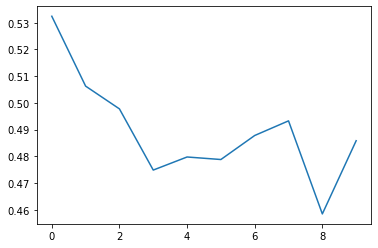

In [28]:
plt.plot(losses)
plt.show()

# Making Predictions

In [29]:
def predict(text):
    text = torch.tensor(text_pipeline(text))    
    offsets = torch.tensor(text.size(0)).unsqueeze(0)
    pred = net(text.to(device), offsets.to(device))
    if pred.round().squeeze(1) == 0:
        print("Negative", round(pred.item(), 3))
    else:
        print("Positive", round(pred.item(), 3))
    

In [30]:
text = torch.tensor(text_pipeline("hello there kid"))    
text.shape
offsets = torch.tensor(text.size(0)).unsqueeze(0)

In [31]:
predict("I'm having a wonderful day")

Positive 0.993


In [32]:
predict("I'm having an awful day")

Negative 0.003


In [33]:
predict("Love is in the air tonight")

Positive 0.999


In [34]:
predict("The steak at that restaurant is the worst")

Negative 0.019


In [35]:
predict("That was a beautiful movie but the story was mediocre")

Positive 0.818


In [36]:
predict("That test this morning was so hard, I must've bombed it!")


Negative 0.24
